In [70]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [71]:
import numpy as np
import pandas as pd

In [72]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [73]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [74]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [75]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [76]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [77]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [78]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [79]:
#check the columns in tables
inspector = inspect(engine)

columns_measurement = inspector.get_columns('measurement')
print("Measurement")
print("-----------")
for column in columns_measurement:
    print(column['name'], column["type"])
    
columns_station = inspector.get_columns('station')
print("\n Stations")
print("-----------")
for column in columns_station:
    print(column['name'], column["type"])

Measurement
-----------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

 Stations
-----------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [80]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

latestdatestr = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#print(f"LatestDate: {latestdatestr[0]}")

latestdate = dt.datetime.strptime(latestdatestr[0], '%Y-%m-%d')
twelve_months_qry = dt.date(latestdate.year -1, latestdate.month, latestdate.day)
twelve_months_qry

datetime.date(2016, 8, 23)

In [81]:
# Perform a query to retrieve the data and precipitation scores
precipitationqry = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= twelve_months_qry).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

precipitation_df = pd.DataFrame(precipitationqry, columns=['Date','Precipitation'])
precipitation_df = precipitation_df.dropna(how='any') # clean up non value entries
precipitation_df = precipitation_df.sort_values(["Date"], ascending=True)
precipitation_df = precipitation_df.set_index("Date")
precipitation_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


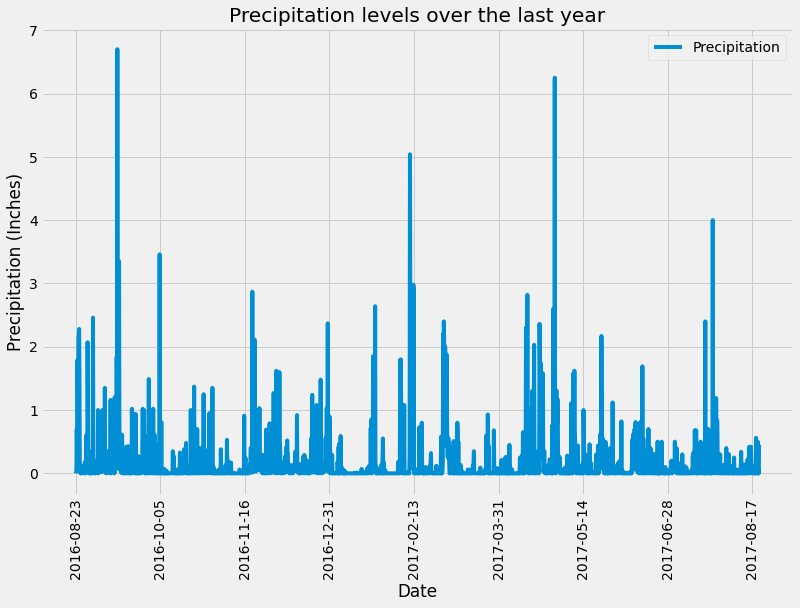

In [82]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(rot=90, figsize=(12,8))
plt.ylabel('Precipitation (Inches)')
plt.title("Precipitation levels over the last year")
plt.show()

In [46]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [83]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(func.count(Station.id)).all()
stations

[(9)]

In [84]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_count = session.query(Measurement.station, Station.name, func.count(Measurement.station)).\
    filter(Measurement.station == Station.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
stations_count

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [85]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [86]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_USC00519281_data =  session.query(Measurement.date, Station.name, Measurement.tobs).\
                    filter(Measurement.station == Station.station).\
                    filter(Measurement.station == 'USC00519281').\
                    filter(Measurement.date > twelve_months_qry).all()
station_USC00519281_data[:5]

[('2016-08-24', 'WAIHEE 837.5, HI US', 77.0),
 ('2016-08-25', 'WAIHEE 837.5, HI US', 80.0),
 ('2016-08-26', 'WAIHEE 837.5, HI US', 80.0),
 ('2016-08-27', 'WAIHEE 837.5, HI US', 75.0),
 ('2016-08-28', 'WAIHEE 837.5, HI US', 73.0)]

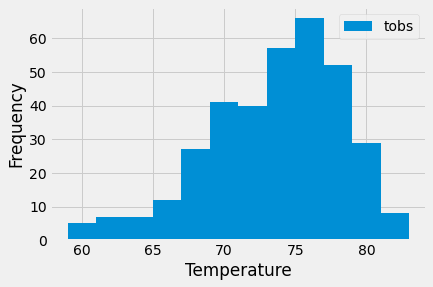

In [91]:
station_USC00519281_df= pd.DataFrame(station_USC00519281_data)
station_USC00519281_df.plot(kind="hist",bins=12)
plt.xlabel("Temperature")
#plt.show()

## Bonus Challenge Assignment - Temparature Analysis II

In [98]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
     
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-03-30', '2017-04-15'))

[(67.0, 74.62037037037037, 82.0)]


In [102]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
import datetime as dt

prev_year_start = dt.date(2017, 3, 30) - dt.timedelta(days=365)
prev_year_end = dt.date(2017, 4, 15) - dt.timedelta(days=365)

tmin, tavg, tmax = calc_temps(prev_year_start.strftime("%Y-%m-%d"), prev_year_end.strftime("%Y-%m-%d"))[0]
print(tmin, tavg, tmax)

62.0 72.86238532110092 79.0


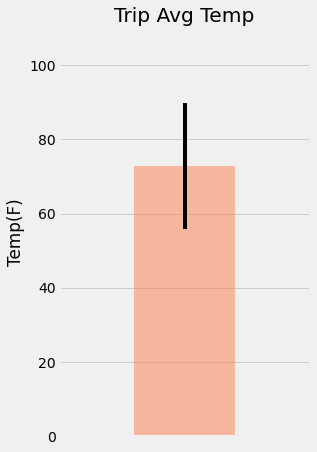

In [105]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
peak_to_peak_yerr = tmax - tmin

x_value = 1

plt.figure(figsize=(4,7))
plt.xticks([])
plt.bar(x_value ,tavg, yerr=peak_to_peak, color='coral', alpha=0.5, align='center')


plt.xlim(0, 2)
plt.ylim(0, 110)
plt.ylabel("Temp(F)")
plt.title("Trip Avg Temp")
plt.show()

## Daily rainfall average

In [108]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date = '2015-03-30'
end_date = '2015-04-15'

rainfall = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
        filter(Measurement.station == Station.station).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= '2015-04-15').\
        group_by(Station.station).\
        order_by(func.sum(Measurement.prcp).desc()).all()

#rainfall

stations = pd.DataFrame(rainfall, columns=['Station','Name','Latitude','Longitude','Elevation','PrcpSum'])
stations

,Station,Name,Latitude,Longitude,Elevation,PrcpSum
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,6.26
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2.58
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,1.33
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.19
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.53
5,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,0.10
6,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.09
7,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.03


In [111]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
 
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("04-02")

[(53.0, 71.82142857142857, 79.0)]

In [130]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_start_date = '2021-03-30'
trip_end_date = '2021-04-15'

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(trip_start_date, trip_end_date, freq='D')

# Stip off the year and save a list of %m-%d strings
trip_month_day = trip_dates.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
dailynormals = []
for date in trip_month_day:
    dailynormals.append(*daily_normals(date))
    
dailynormals

[(62.0, 72.17543859649123, 79.0),
 (61.0, 71.875, 79.0),
 (60.0, 71.87931034482759, 80.0),
 (53.0, 71.82142857142857, 79.0),
 (55.0, 72.2280701754386, 78.0),
 (58.0, 72.01639344262296, 78.0),
 (61.0, 72.28813559322033, 80.0),
 (67.0, 71.57142857142857, 77.0),
 (63.0, 71.10526315789474, 78.0),
 (66.0, 72.10526315789474, 77.0),
 (62.0, 71.6140350877193, 78.0),
 (64.0, 71.40350877192982, 79.0),
 (65.0, 72.49180327868852, 82.0),
 (65.0, 72.22413793103448, 80.0),
 (64.0, 71.52542372881356, 79.0),
 (65.0, 72.75, 81.0),
 (61.0, 71.79310344827586, 79.0)]

In [131]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(dailynormals, columns=["Tmin", "Tavg", "Tmax"])
normals_df['Date'] = trip_dates
normals_df.set_index('Date', inplace=True)
normals_df.head()

,Tmin,Tavg,Tmax
Date,,,
2021-03-30,62.0,72.175439,79.0
2021-03-31,61.0,71.875000,79.0
2021-04-01,60.0,71.879310,80.0
2021-04-02,53.0,71.821429,79.0
2021-04-03,55.0,72.228070,78.0


Text(0, 0.5, 'Temperature (F)')

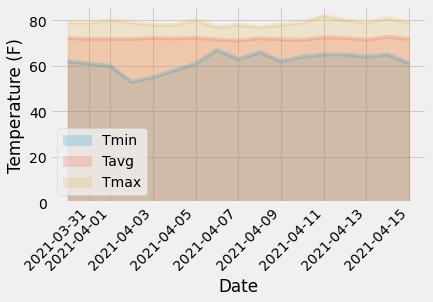

In [142]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind='area', stacked=False, x_compat =True,  rot=45, alpha=0.2)
#plt.tight_layout()
plt.ylabel('Temperature (F)')

In [144]:
session.close()